In [34]:

from tensorflow.keras.datasets import cifar100
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Input

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import metrics
import scipy

print(tf.__version__)

2.15.0


In [24]:
# Load dataset

# path for pop!_OS
#file_name = '/home/csalitre/School/ecgr-4127/tinyml/datasets/hw4_data.csv'

# path for WSL
file_name = '/home/csalitre/school/ecgr-4127/tinyml/datasets/hw4_data.csv'
df = pd.read_csv(file_name)

df.head(5)

,model_output,prediction,true_class
0,6.039733,1,1
1,2.450787,0,0
2,2.417883,0,1
3,-0.451535,0,0
4,1.173396,0,0


In [25]:
# convert columns to numpy arrays
model_output = df['model_output'].to_numpy()
prediction = df['prediction'].to_numpy()
true_class = df['true_class'].to_numpy()

model_output[:5]

array([ 6.03973338,  2.45078686,  2.4178825 , -0.4515346 ,  1.17339604])

In [26]:
# Find metrics TP, FP, TN, FN, precision and recall
true_positives = ((df['prediction'] == 1) & (df['true_class'] == 1)).sum()
false_positives = ((df['prediction'] == 1) & (df['true_class'] == 0)).sum()
true_negatives = ((df['prediction'] == 0) & (df['true_class'] == 0)).sum()
false_negatives = ((df['prediction'] == 0) & (df['true_class'] == 1)).sum()

precision = round(true_positives / (true_positives + false_positives), 4)
recall = round(true_positives / (true_positives + false_negatives), 4)

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_negatives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

True Positives: 26
False Positives: 21
True Negatives: 150
False Negatives: 21
Precision: 0.8966
Recall: 0.5532


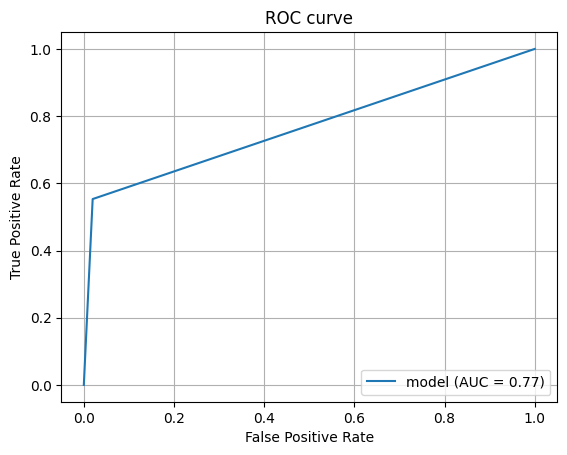

In [27]:
# Plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(true_class, prediction)
roc_auc = metrics.auc(fpr, tpr)

metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model').plot()

plt.title('ROC curve')
plt.grid(True)
plt.show()


In [28]:
#find the minimum FP rate you can achieve to correctly detect at least 90% of all actual positives
#FP = (true positives/precision) - true positives -- precision = 0.9
min_false_positives = (true_positives / precision) - true_positives
print(f"The minimum False Positive Rate: {min_false_positives}")

The minimum False Positive Rate: 2.998438545616775


In [36]:
# Load the Dataset
(all_train_images, all_train_labels), (all_test_images, all_test_labels) = \
  tf.keras.datasets.cifar100.load_data()

all_train_labels = all_train_labels.squeeze()
all_test_labels = all_test_labels.squeeze()

input_shape = all_train_images.shape[1:]
all_train_images = all_train_images / 255.0
all_test_images = all_test_images / 255.0

print("{:4d} Training Images range from {:2.3f} to {:2.3f}".format(
    len(all_train_labels), np.min(all_train_images), np.max(all_train_images)))
print("{:4d} Test Images range from {:2.3f} to {:2.3f}".format(
    len(all_test_labels), np.min(all_test_images), np.max(all_test_images)))




50000 Training Images range from 0.000 to 1.000
10000 Test Images range from 0.000 to 1.000


In [38]:
def plot_train_hist(train_hist):
  plt.subplot(2,1,1)
  plt.plot(train_hist.epoch, train_hist.history['loss'], label='Train Loss')
  if 'val_loss' in train_hist.history:
    plt.plot(train_hist.epoch, train_hist.history['val_loss'], label='Val Loss')
  plt.grid(True)
  plt.legend()
  
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['accuracy'], label="Train Accuracy")
  if 'val_accuracy' in train_hist.history:
    plt.plot(train_hist.epoch, train_hist.history['val_accuracy'], label="Val Accuracy")
  plt.legend()
  plt.grid(True)

In [39]:
def build_model(input_shape=(32,32,3), num_classes=2):
    
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), 
                  activation="relu", padding='same')(inputs)
    y = layers.BatchNormalization()(x) # save the result in y for the skip connection

    
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same')(y)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(2,2),
              activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # match the channel counts and feature map size for the skip ADD.
    y = layers.Conv2D(128, kernel_size=(1,1), strides=(4,4))(y) 
    y = layers.add((x,y))

    x = layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding='same')(y)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.add((x,y))

    x = layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding='same')(y)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.add((x,y))

    x = layers.MaxPooling2D(pool_size=(4,4))(y)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = outputs = layers.Dense(2)(x)

    model = keras.Model(inputs, outputs)
    return model

In [40]:
def build_model_sm(input_shape=(32,32,3), num_classes=2):
    
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), 
                  activation="relu", padding='same')(inputs)
    y = layers.BatchNormalization()(x) # save the result in y for the skip connection

    
    x = layers.SeparableConv2D(32, kernel_size=(3,3), strides=(2,2), padding='same')(y)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(pool_size=(8,8))(y)
    x = layers.Flatten()(x)

    x = layers.Dense(64, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    x = outputs = layers.Dense(2)(x)

    model = keras.Model(inputs, outputs)
    return model


In [41]:
model = build_model_sm(input_shape=input_shape, num_classes=100)

EPOCHS = 20

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
train_hist = model.fit(all_train_images, all_train_labels, epochs=EPOCHS)